
<div class="alert alert-block alert-info">
   <h2 align="center"> <center><b> Reinforcement Learning Assignment 1 - The Reinforcement Learning Framework</b></center></h2>

<br>
<center><font size="3">This notebook is a part of teaching material for ELEC-E8125</font></center>
<center><font size="3">Sep 4, 2023 - Nov 30, 2023</font></center>
<center><font size="3">Aalto University</font></center>
</div>


<a id='TOC'></a>

<div class="alert alert-block alert-success">
    
# Table of contents
* <a href='#1.'> 1. Introduction </a>
* <a href='#1.1'> 1.1 Learning Objectives </a>
* <a href='#1.2'> 1.2 Code Structure & Files </a>
* <a href='#2.'> 2. Cartpole</a>
* <a href='#3.'> 3. Reacher</a>
* <a href='#4.'> 4. Submitting </a>
* <a href='#4.1'> 4.1 Feedback </a>
* <a href='#5.'> References</a>

<a href='#T1'><b>Student Task 1.</b> Training a Model for Simple Cartpole Environment (10 points)</a>\
<a href='#Q1'><b>Student Question 1.1</b> Learning (10 points)</a>\
<a href='#T2'><b>Student Task 2.</b> Investigating Training Performance (10 points) </a>\
<a href='#Q2'><b>Student Question 2.1</b> Analysis of Training Performance (15 points) </a>\
<a href='#Q3'><b>Student Question 2.2</b> Stochasticity (10 points) </a>\
<a href='#T3'><b>Student Task 3.</b> Reward Functions (20 points) </a>\
<a href='#T4'><b>Student Task 4.</b> Visualizing Behavior (10 points) </a>\
<a href='#Q4'><b>Student Question 4.1</b> Achieved Peformance (5 points)\
<a href='#Q5'><b>Student Question 4.2</b> Analysis of Behaviour (10 points)</a>
    
**Total Points:** 100

# 1. Introduction <a id='1.'></a>
In this exercise we will take a first look at a reinforcement learning environment, its components and modify the reward function of a simple agent.

In this notebook two environments are used: Cartpole and Reacher. The cartpole environment is taken from [OpenAI's Gym library](https://www.gymlibrary.dev/). The reacher environment is custom made (and defined in ```reacher.py```) but utilizes the Gym API.

## 1.1 Learning Objectives: <a id='1.1'></a>
- To become familiar with assignment structure and the agent-environment relationshp
- To understand the effects of stochasticity
- To understand and explore the effects of task definition

## 1.2 Code Structure & Files <a id='1.2'></a>

The ```train.py``` file instantiates the environment and the RL agent that acts in it. The ```agent.py``` file contains the implementation of a simple reinforcement learning agent; for the sake of this exercise, you can assume it to be a black box (you don’t need to understand how it works, although you are encouraged to study it in more detail). You don’t have to edit any other file other than ```ex1.ipynb``` to complete this exercise.
```
├───cfg                  # Config files for environments e.g. define the maximum number of steps in an episode.
├───imgs                 # Images used in notebook
├───results 
│   ├───logging          # Contains logged data
│   ├───model            # Contains the policies learned
│   └───video            # Contains videos for each environment
│       └───CartPole-v0
│       │  └───test      # Videos saved during testing
│       │  └───train     # Videos saved during training
│       └───SpinningReacher-v0
│           └───test
│           └───train
├───wandb                # Data saved for wandb
│   ex1.ipynb            # Main assignment file containing tasks <---------
│   feedback.ipynb       # Please give feedback in here
│   README.ipynb         # This file
│   agent.py             # Contains functions that govern the policy
│   reacher.py           # Defines the reacher environment
│   train.py             # Contains training and testing functions
│   utils.py             # Contains useful functions 
```

Please consult ```README.md``` for more details the assignments.

The assignments use wandb to visualize data. You need to set Wandb up and login using the command below.

In [1]:
! wandb login # Insert API key here. You can get your API key from https://wandb.ai/authorize

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 
Aborted!


In [8]:
import wandb
wandb.login()

AttributeError: module 'wandb' has no attribute 'login'

In [5]:
from pathlib import Path # to find directory
work_dir = Path().cwd()/'results'
import os
os.environ['WANDB_NOTEBOOK_NAME'] = str(Path().cwd()/'ex1.ipynb') # Detects notebook for wandb

import train as t # for training
import utils as u # helper functions

import numpy as np # The numpy library can be used for math functions
import torch # Used to manage policy and learning
from IPython.display import Video, display # to display videos

# 2. Cartpole <a id='2.'></a>

The Cartpole environment consists of a cart and a pole mounted on top of it, as shown in Figure 1. The cart can move either to the left or to the right. The goal is to balance the pole in a vertical position in order to prevent it from falling down. The cart should also stay within limited distance from the center (trying to move outside screen boundaries is considered a failure).

<figure>
<img src="imgs/cartpole.png" width="400px">
<figcaption style="text-align: center"> Figure 1: The Cartpole environment  </figcaption>
</figure>

The state and the observation are four element vectors:

$$
o=s=\left(\begin{array}{c}
x \\
\dot{x} \\
\theta \\
\dot{\theta}
\end{array}\right) \text {, }
$$

where $x$ is the position of the cart, $\dot{x}$ is its velocity, $\theta$ is the angle of the pole w.r.t. the vertical axis, and $\dot{\theta}$ is the angular velocity of the pole.

In the standard formulation, a reward of 1 is given for every timestep the pole remains balanced. Upon failing (the pole falls) or completing the task, an episode is finished.

The training script will record videos of the agent’s learning progress during training, and the recorded videos are saved to ```results/video/CartPole-v0/train```. By default, the training information is saved to ```results/logging/CartPole-v0_logging.pkl``` as well as on cloud via wandb. When the training is finished, the models are saved to ```results/model/Cartpole-v0_params.pt```. The models can be tested by setting ```testing=true``` in ```cfg_args```, and if the models are saved to a different path, you can use ```model_path=<YOUR MODEL PATH>``` to indicate it. Videos of the agent’s behaviour during testing are saved to ```results/video/CartPole-v0/test```.

<a id='T1'></a>
<div class=" alert alert-warning">
    <h3><b>Student Task 1.</b> Training a Model for Simple Cartpole Environment (10 points) </h3> 

This task requires you to train a model for the cartpole environment with 100 timesteps per episode and then report the training plot using 'Weights \& Biases'. Then test the model for 1000 timesteps and report average reward. To do this, you can simply run the code in the cells below. 

To see a full list of options that can be passed through ```cfg_args``` consult the configuation file found in ```cfg/```.

- **1st:** setup 'Weights \& Biases', check the README for help. 
- **2nd:** Run training over 100 steps per episode by using ```t.train``` function. See the cell below. 
- **3rd:** Export the training plot ```episodesep_reward``` from wandb (see ```README.md```) and attach below.
- **4th:** Run testing over 1000 steps by using ```t.test``` function. See the cell below. See the cell below. Notice ```max_episode_steps``` parameter. 
- **5th:** Report the average reward after testing the model.
    
🔝	<a href='#TOC'><b>Table of Contents</b></a>
</div>


In [3]:
t.train(cfg_path=Path().cwd()/'cfg'/'cartpole_v1.yaml', 
        cfg_args=dict(seed=1, max_episode_steps=100)) # < 5 mins

Numpy/Torch/Random Seed:  1


wandb: Currently logged in as: bencer (r-l). Use `wandb login --relogin` to force relogin


/opt/software/lib/python3.10/site-packages/gymnasium/wrappers/record_video.py:94: UserWarning: WARN: Overwriting existing videos at /notebooks/rl2023/ex1/results/video/CartPole-v1/train folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


Configuration Settings: {'exp_name': 'ex1', 'seed': 1, 'env_name': 'CartPole-v1', 'max_episode_steps': 100, 'train_episodes': 500, 'batch_size': 64, 'min_update_samples': 2000, 'testing': False, 'model_path': 'default', 'save_video': True, 'save_model': True, 'save_logging': True, 'silent': False, 'use_wandb': True, 'run_suffix': 0}
Training device: cpu
Observation space dimensions: 4
Action space dimensions: 2

Episode 0 finished. Total reward: 28.0 (28 timesteps)
Episode 1 finished. Total reward: 34.0 (34 timesteps)
Episode 2 finished. Total reward: 17.0 (17 timesteps)
Episode 3 finished. Total reward: 11.0 (11 timesteps)
Episode 4 finished. Total reward: 34.0 (34 timesteps)
Episode 5 finished. Total reward: 18.0 (18 timesteps)
Episode 6 finished. Total reward: 76.0 (76 timesteps)
Episode 7 finished. Total reward: 12.0 (12 timesteps)
Episode 8 finished. Total reward: 10.0 (10 timesteps)
Episode 9 finished. Total reward: 41.0 (41 timesteps)
Episode 10 finished. Total reward: 33.0 (33 

<figure>
<img src="imgs/cartpole-reward.png" width="400px">
<figcaption style="text-align: center"> Figure x: Rewards for Cartpole  </figcaption>
</figure>

The command below will evaluate the trained model in 10 episodes and report the average reward (and episode length) for these 10 episodes.

In [4]:
t.test(episodes=10, 
       cfg_path=Path().cwd()/'cfg'/'cartpole_v1.yaml', 
       cfg_args=dict(testing=True, seed=None, max_episode_steps=1000, use_wandb=False))

Numpy/Torch/Random Seed:  501
Loading model from /notebooks/rl2023/ex1/results/model/CartPole-v1_params.pt ...
Testing...


/opt/software/lib/python3.10/site-packages/gymnasium/wrappers/record_video.py:94: UserWarning: WARN: Overwriting existing videos at /notebooks/rl2023/ex1/results/video/CartPole-v1/test folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


Test ep reward: 137.0 seed: 88
Test ep reward: 127.0 seed: 672
Test ep reward: 131.0 seed: 680
Test ep reward: 127.0 seed: 592
Test ep reward: 135.0 seed: 481
Test ep reward: 137.0 seed: 78
Test ep reward: 147.0 seed: 735
Test ep reward: 156.0 seed: 852
Test ep reward: 132.0 seed: 694
Test ep reward: 126.0 seed: 965
Average test reward: 135.5 episode length: 135.5


Average test reward: 135.5

The agent acting in the environment can be seen using the following command. Change the ```path``` to pick the episode you want to visualize. Bear in mind by default video saving for training is taken every 50 episodes.

In [2]:
#! pip install html
from IPython.display import Video, display, HTML

In [31]:
# Train Result
video_dir = work_dir/'video'/'CartPole-v1'/'train'

# List all MP4 files in the directory
mp4_files = [file for file in os.listdir(video_dir) if file.endswith(".mp4")]
frame_colors = ['#FF5733', '#33FF57', '#5733FF', '#FFFF33', '#33FFFF', '#FF33FF']
# Display each MP4 file
for i, mp4_file in enumerate(mp4_files):
    video_path = os.path.join(video_dir, mp4_file)
    video = Video(video_path, embed=True, html_attributes="loop autoplay", width=200, height=100)
    frame_color = frame_colors[i % len(frame_colors)]
    video_frame = HTML(f'<div style="width: 200px; height: 100px;; border: 1px solid #FF5733;">{video._repr_html_()}</div>')
    print("test/",mp4_file)
    display(video_frame)

test/ ex1-episode-0.mp4


test/ ex1-episode-50.mp4


test/ ex1-episode-100.mp4


test/ ex1-episode-150.mp4


test/ ex1-episode-200.mp4


test/ ex1-episode-250.mp4


test/ ex1-episode-300.mp4


test/ ex1-episode-350.mp4


test/ ex1-episode-400.mp4


test/ ex1-episode-450.mp4


test/ ex1-episode-500.mp4


In [6]:
# Test Result

video_dir = work_dir/'video'/'CartPole-v1'/'test'

# List all MP4 files in the directory
mp4_files = [file for file in os.listdir(video_dir) if file.endswith(".mp4")]
frame_colors = ['#FF5733', '#33FF57', '#5733FF', '#FFFF33', '#33FFFF', '#FF33FF']
# Display each MP4 file
for i, mp4_file in enumerate(mp4_files):
    video_path = os.path.join(video_dir, mp4_file)
    video = Video(video_path, embed=True, html_attributes="loop autoplay", width=200, height=100)
    frame_color = frame_colors[i % len(frame_colors)]
    video_frame = HTML(f'<div style="width: 200px; height: 100px;; border: 1px solid #5733FF;">{video._repr_html_()}</div>')
    print("test/",mp4_file)
    display(video_frame)

NameError: name 'HTML' is not defined

<a id='Q1'></a>
<div class=" alert alert-warning">
    <h3><b>Student Question 1.1</b> Learning (10 points) </h3> 

Test the trained model from Task 1 five times with different random seeds. Did the same model, trained to balance for 100 timesteps, learn to always balance the pole for 1000 timesteps? Why/why not?
    
🔝	<a href='#TOC'><b>Table of Contents</b></a>
</div>


In [4]:
t.test(episodes=10, 
       cfg_path=Path().cwd()/'cfg'/'cartpole_v1.yaml', 
       cfg_args=dict(testing=True, seed=None, max_episode_steps=1000, use_wandb=False))

Numpy/Torch/Random Seed:  693
Loading model from /notebooks/rl2023/ex1/results/model/CartPole-v1_params.pt ...
Testing...


/opt/software/lib/python3.10/site-packages/gymnasium/wrappers/record_video.py:94: UserWarning: WARN: Overwriting existing videos at /notebooks/rl2023/ex1/results/video/CartPole-v1/test folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


Test ep reward: 143.0 seed: 243
Test ep reward: 138.0 seed: 273
Test ep reward: 144.0 seed: 438
Test ep reward: 125.0 seed: 962
Test ep reward: 127.0 seed: 461
Test ep reward: 129.0 seed: 242
Test ep reward: 131.0 seed: 756
Test ep reward: 123.0 seed: 926
Test ep reward: 141.0 seed: 165
Test ep reward: 146.0 seed: 565
Average test reward: 134.7 episode length: 134.7


In [5]:
t.test(episodes=10, 
       cfg_path=Path().cwd()/'cfg'/'cartpole_v1.yaml', 
       cfg_args=dict(testing=True, seed=None, max_episode_steps=1000, use_wandb=False))

Numpy/Torch/Random Seed:  762
Loading model from /notebooks/rl2023/ex1/results/model/CartPole-v1_params.pt ...
Testing...


/opt/software/lib/python3.10/site-packages/gymnasium/wrappers/record_video.py:94: UserWarning: WARN: Overwriting existing videos at /notebooks/rl2023/ex1/results/video/CartPole-v1/test folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


Test ep reward: 131.0 seed: 55
Test ep reward: 134.0 seed: 649
Test ep reward: 125.0 seed: 470
Test ep reward: 127.0 seed: 351
Test ep reward: 125.0 seed: 874
Test ep reward: 137.0 seed: 929
Test ep reward: 143.0 seed: 225
Test ep reward: 140.0 seed: 495
Test ep reward: 134.0 seed: 337
Test ep reward: 134.0 seed: 397
Average test reward: 133.0 episode length: 133.0


In [6]:
t.test(episodes=10, 
       cfg_path=Path().cwd()/'cfg'/'cartpole_v1.yaml', 
       cfg_args=dict(testing=True, seed=None, max_episode_steps=1000, use_wandb=False))

Numpy/Torch/Random Seed:  757
Loading model from /notebooks/rl2023/ex1/results/model/CartPole-v1_params.pt ...
Testing...
Test ep reward: 136.0 seed: 291
Test ep reward: 124.0 seed: 796
Test ep reward: 133.0 seed: 535
Test ep reward: 138.0 seed: 398
Test ep reward: 127.0 seed: 970
Test ep reward: 126.0 seed: 127
Test ep reward: 127.0 seed: 519
Test ep reward: 147.0 seed: 768
Test ep reward: 122.0 seed: 730
Test ep reward: 131.0 seed: 332
Average test reward: 131.1 episode length: 131.1


In [7]:
t.test(episodes=10, 
       cfg_path=Path().cwd()/'cfg'/'cartpole_v1.yaml', 
       cfg_args=dict(testing=True, seed=None, max_episode_steps=1000, use_wandb=False))

Numpy/Torch/Random Seed:  912
Loading model from /notebooks/rl2023/ex1/results/model/CartPole-v1_params.pt ...
Testing...
Test ep reward: 130.0 seed: 854
Test ep reward: 138.0 seed: 641
Test ep reward: 129.0 seed: 77
Test ep reward: 137.0 seed: 600
Test ep reward: 137.0 seed: 392
Test ep reward: 135.0 seed: 181
Test ep reward: 126.0 seed: 844
Test ep reward: 135.0 seed: 443
Test ep reward: 137.0 seed: 715
Test ep reward: 149.0 seed: 262
Average test reward: 135.3 episode length: 135.3


In [8]:
t.test(episodes=10, 
       cfg_path=Path().cwd()/'cfg'/'cartpole_v1.yaml', 
       cfg_args=dict(testing=True, seed=None, max_episode_steps=1000, use_wandb=False))

Numpy/Torch/Random Seed:  612
Loading model from /notebooks/rl2023/ex1/results/model/CartPole-v1_params.pt ...
Testing...
Test ep reward: 121.0 seed: 646
Test ep reward: 137.0 seed: 906
Test ep reward: 143.0 seed: 243
Test ep reward: 125.0 seed: 248
Test ep reward: 128.0 seed: 570
Test ep reward: 132.0 seed: 694
Test ep reward: 136.0 seed: 2
Test ep reward: 142.0 seed: 390
Test ep reward: 130.0 seed: 391
Test ep reward: 127.0 seed: 505
Average test reward: 132.1 episode length: 132.1


Tested with random seeds 693, 762, 757, 912, 612, the model always fail to balance in 1000 timesteps. It seems the policy only tries to maximize rewards until around 100 timesteps. Also, the agents may adopt policies will not work in logner timespan. For example, the cart may head strait towards one direction indefinitely in 100 timesteps. In 1000 timesteps, it will just hit the boundary.

<a id='T2'></a>
<div class=" alert alert-warning">
    <h3><b>Student Task 2.</b> Investigating Training Performance (10 points) </h3> 

Repeat the experiment in Task 1 five times, each time training the model from scratch with 100 timesteps and testing it for 1000 timesteps. Use a different seed number for each training/testing cycle. You can use the box below to write a small script to do this. Use the result textbox below to report the average test reward for each repeat. 
    
🔝	<a href='#TOC'><b>Table of Contents</b></a>
</div>


In [12]:
seeds = np.random.rand(5,) * 100
print(seeds)

[42.85313597 36.96944454 94.75821371  9.29509878 66.03556487]


In [17]:
for seed in seeds:
    t.train(cfg_path=Path().cwd()/'cfg'/'cartpole_v1.yaml', 
        cfg_args=dict(seed=int(seed), max_episode_steps=100)) # < 5 mins
    t.test(episodes=10, 
           cfg_path=Path().cwd()/'cfg'/'cartpole_v1.yaml', 
           cfg_args=dict(testing=True, seed=None, max_episode_steps=1000, use_wandb=False))

Numpy/Torch/Random Seed:  42


ep_reward,▂▃▂▂▂▁▄▂▁▄▄▁▃▃▁▂▁▇▃▁▇▄▂▁▄▁▆▄▂▂▆▁▂▂▂▄▅▂█▁
episodes,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
num_updates,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
timesteps,▂▃▂▂▂▁▄▂▁▄▄▁▃▃▁▂▁▇▃▁▇▄▂▁▄▁▆▄▂▂▆▁▂▂▂▄▅▂█▁
ep_reward,30.0
episodes,200
num_updates,0
timesteps,30


Configuration Settings: {'exp_name': 'ex1', 'seed': 42, 'env_name': 'CartPole-v1', 'max_episode_steps': 100, 'train_episodes': 500, 'batch_size': 64, 'min_update_samples': 2000, 'testing': False, 'model_path': 'default', 'save_video': True, 'save_model': True, 'save_logging': True, 'silent': False, 'use_wandb': True, 'run_suffix': 0}
Training device: cpu
Observation space dimensions: 4
Action space dimensions: 2

Episode 0 finished. Total reward: 23.0 (23 timesteps)
Episode 1 finished. Total reward: 25.0 (25 timesteps)
Episode 2 finished. Total reward: 19.0 (19 timesteps)
Episode 3 finished. Total reward: 15.0 (15 timesteps)
Episode 4 finished. Total reward: 26.0 (26 timesteps)
Episode 5 finished. Total reward: 26.0 (26 timesteps)
Episode 6 finished. Total reward: 16.0 (16 timesteps)
Episode 7 finished. Total reward: 26.0 (26 timesteps)
Episode 8 finished. Total reward: 29.0 (29 timesteps)
Episode 9 finished. Total reward: 20.0 (20 timesteps)
Episode 10 finished. Total reward: 21.0 (21

ep_reward,▁▂▃▁▃▁▂▂▅▂▁▄▃▂█▅█▄▄█▆███████████████████
episodes,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
num_updates,▁▁▁▁▁▁▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▁▁▁▁▁
timesteps,▁▂▃▁▃▁▂▂▅▂▁▄▃▂█▅█▄▄█▆███████████████████
ep_reward,98.0
episodes,500
num_updates,0
timesteps,98


Configuration Settings: {'exp_name': 'ex1', 'seed': 36, 'env_name': 'CartPole-v1', 'max_episode_steps': 100, 'train_episodes': 500, 'batch_size': 64, 'min_update_samples': 2000, 'testing': False, 'model_path': 'default', 'save_video': True, 'save_model': True, 'save_logging': True, 'silent': False, 'use_wandb': True, 'run_suffix': 0}
Training device: cpu
Observation space dimensions: 4
Action space dimensions: 2

Episode 0 finished. Total reward: 23.0 (23 timesteps)
Episode 1 finished. Total reward: 24.0 (24 timesteps)
Episode 2 finished. Total reward: 14.0 (14 timesteps)
Episode 3 finished. Total reward: 19.0 (19 timesteps)
Episode 4 finished. Total reward: 19.0 (19 timesteps)
Episode 5 finished. Total reward: 21.0 (21 timesteps)
Episode 6 finished. Total reward: 19.0 (19 timesteps)
Episode 7 finished. Total reward: 31.0 (31 timesteps)
Episode 8 finished. Total reward: 12.0 (12 timesteps)
Episode 9 finished. Total reward: 9.0 (9 timesteps)
Episode 10 finished. Total reward: 30.0 (30 t

ep_reward,▂▁▂▅▁▂▁▁▂▂▁▂▅▂▁▁▆▃▆▆██▇▆██▆█████████████
episodes,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
num_updates,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▁▁▁▁▁▁▁▁▁▁▁
timesteps,▂▁▂▅▁▂▁▁▂▂▁▂▅▂▁▁▆▃▆▆██▇▆██▆█████████████
ep_reward,100.0
episodes,500
num_updates,0
timesteps,100


Configuration Settings: {'exp_name': 'ex1', 'seed': 94, 'env_name': 'CartPole-v1', 'max_episode_steps': 100, 'train_episodes': 500, 'batch_size': 64, 'min_update_samples': 2000, 'testing': False, 'model_path': 'default', 'save_video': True, 'save_model': True, 'save_logging': True, 'silent': False, 'use_wandb': True, 'run_suffix': 0}
Training device: cpu
Observation space dimensions: 4
Action space dimensions: 2

Episode 0 finished. Total reward: 30.0 (30 timesteps)
Episode 1 finished. Total reward: 27.0 (27 timesteps)
Episode 2 finished. Total reward: 20.0 (20 timesteps)
Episode 3 finished. Total reward: 23.0 (23 timesteps)
Episode 4 finished. Total reward: 27.0 (27 timesteps)
Episode 5 finished. Total reward: 19.0 (19 timesteps)
Episode 6 finished. Total reward: 16.0 (16 timesteps)
Episode 7 finished. Total reward: 11.0 (11 timesteps)
Episode 8 finished. Total reward: 40.0 (40 timesteps)
Episode 9 finished. Total reward: 41.0 (41 timesteps)
Episode 10 finished. Total reward: 70.0 (70

ep_reward,▂▂▁▂▁▁▂▁▁▃▄▁▇█▂▁▂▆▁██▅▆█▃██████████▇████
episodes,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
num_updates,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
timesteps,▂▂▁▂▁▁▂▁▁▃▄▁▇█▂▁▂▆▁██▅▆█▃██████████▇████
ep_reward,100.0
episodes,500
num_updates,0
timesteps,100


Configuration Settings: {'exp_name': 'ex1', 'seed': 9, 'env_name': 'CartPole-v1', 'max_episode_steps': 100, 'train_episodes': 500, 'batch_size': 64, 'min_update_samples': 2000, 'testing': False, 'model_path': 'default', 'save_video': True, 'save_model': True, 'save_logging': True, 'silent': False, 'use_wandb': True, 'run_suffix': 0}
Training device: cpu
Observation space dimensions: 4
Action space dimensions: 2

Episode 0 finished. Total reward: 15.0 (15 timesteps)
Episode 1 finished. Total reward: 21.0 (21 timesteps)
Episode 2 finished. Total reward: 19.0 (19 timesteps)
Episode 3 finished. Total reward: 11.0 (11 timesteps)
Episode 4 finished. Total reward: 13.0 (13 timesteps)
Episode 5 finished. Total reward: 14.0 (14 timesteps)
Episode 6 finished. Total reward: 61.0 (61 timesteps)
Episode 7 finished. Total reward: 13.0 (13 timesteps)
Episode 8 finished. Total reward: 44.0 (44 timesteps)
Episode 9 finished. Total reward: 14.0 (14 timesteps)
Episode 10 finished. Total reward: 23.0 (23 

ep_reward,▁▁▂▁▁▁▃▂▃▁▄▂▂▂▅▁▂█▄▅▃██▇████▇██▂███████▄
episodes,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
num_updates,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▁▁▁▁▁▁▁▁▁▁▁▁
timesteps,▁▁▂▁▁▁▃▂▃▁▄▂▂▂▅▁▂█▄▅▃██▇████▇██▂███████▄
ep_reward,100.0
episodes,500
num_updates,0
timesteps,100


Configuration Settings: {'exp_name': 'ex1', 'seed': 66, 'env_name': 'CartPole-v1', 'max_episode_steps': 100, 'train_episodes': 500, 'batch_size': 64, 'min_update_samples': 2000, 'testing': False, 'model_path': 'default', 'save_video': True, 'save_model': True, 'save_logging': True, 'silent': False, 'use_wandb': True, 'run_suffix': 0}
Training device: cpu
Observation space dimensions: 4
Action space dimensions: 2

Episode 0 finished. Total reward: 13.0 (13 timesteps)
Episode 1 finished. Total reward: 18.0 (18 timesteps)
Episode 2 finished. Total reward: 18.0 (18 timesteps)
Episode 3 finished. Total reward: 32.0 (32 timesteps)
Episode 4 finished. Total reward: 16.0 (16 timesteps)
Episode 5 finished. Total reward: 10.0 (10 timesteps)
Episode 6 finished. Total reward: 9.0 (9 timesteps)
Episode 7 finished. Total reward: 17.0 (17 timesteps)
Episode 8 finished. Total reward: 14.0 (14 timesteps)
Episode 9 finished. Total reward: 20.0 (20 timesteps)
Episode 10 finished. Total reward: 12.0 (12 t

Numpy/Torch/Random Seed: 42, Average test reward: 131.5 episode length: 131.5;
Numpy/Torch/Random Seed: 36, Average test reward: 154.6 episode length: 154.6;
Numpy/Torch/Random Seed:  94, Average test reward: 126.1 episode length: 126.1;
Numpy/Torch/Random Seed:  9, Average test reward: 131.5 episode length: 131.5;
Numpy/Torch/Random Seed:  66, Average test reward: 197.7 episode length: 197.7

<a id='Q2'></a>
<div class=" alert alert-warning">
    <h3><b>Student Question 2.1</b> Analysis of Training Performance (15 points) </h3> 

Are the behavior and performance of the trained models the same every time? Why/why not? Analyze the causes briefly.
    
🔝	<a href='#TOC'><b>Table of Contents</b></a>
</div>


The results are all different with small SD. With more episodes the results might converge.

<a id='Q3'></a>
<div class=" alert alert-warning">
    <h3><b>Student Question 2.2</b> Stochasticity (10 points) </h3> 

What are the implications of this stochasticity, when it comes to comparing reinforcement learning algorithms to each other? Please explain.
    
🔝	<a href='#TOC'><b>Table of Contents</b></a>
</div>


The outcome of each learning will be different since different seeds ultimately leads to different policies after training.

# Reacher <a id='3.'></a>

Now we will focus on designing a reward function for a different environment, the Reacher environment, where a two-joint manipulator needs to reach a goal (see Figure 2).

<figure>
<img src="imgs/reacher.png" width="200px">
<figcaption style="text-align: center"> Figure 2: The Reacher environment  </figcaption>
</figure>

The Cartesian ($x$, $y$) position of the end-effector of the manipulator can be determined following the equation:

$$
 x = L_1 \sin(\theta_0)+L_2 \sin(\theta_0+\theta_1)\\
 y = -L_1 \cos(\theta_0)-L_2 \cos(\theta_0+\theta_1)
$$

where $L1 = 1$, $L2 = 1$ are the lengths, and $\theta_0$, $\theta_1$ the joint angles of the first and second links respectively. The state (and observation) in this environment is the two element vector:

$$
o=s=\left(\begin{array}{c}
\theta_0 \\
\theta_1 \\
\end{array}\right) \text {, }
$$

The action space now consists of 5 "options"; 4 correspond rotating the first/second joint left/right, and the final one performs no motion at all (the configuration doesn’t change). The episode terminates when the agent reaches the target position, marked in red. Now, let us design a custom reward function and use it for training the RL agent.

<a id='T3'></a>
<div class=" alert alert-warning">
    <h3><b>Student Task 3.</b> Reward Functions (20 points) </h3> 

Below two classes are shown that modify the reward function of the reacher function provided in ```reacher.py```. Edit the function ```get_reward``` _below_ (not in ```reacher.py```) in both classes. For each class, write a reward function to incentivise the agent to learn the following behaviors:

Class 1) ```SpinningReacherEnv```: Keep the manipulator rotating clockwise continuously (w.r.t. angle θ_0). You can use a lower number of training episodes for this, e.g. train(cfg_args=dict(env_name='SpinningReacher-v0', train_episodes=200), overrides=['env=reacher_v1'])

Class 2) ```TargetReacherEnv```: Reach the goal point located in x = [1.0,1.0] (marked in red). Use at least 500 training episodes.
    
Train one model for each behavior. 

**Hint:** Use the observation vector to get the quantities required to compute the new reward (such as the position of the manipulator). You can get the Cartesian position of the end-effector with ```self.get_cartesian_pos(state)```.
            
🔝	<a href='#TOC'><b>Table of Contents</b></a>
</div>


In [6]:
from reacher import ReacherEnv
from typing import Optional
from gymnasium.envs.registration import register

class SpinningReacherEnv(ReacherEnv):
    def __init__(self, render_mode: Optional[str] = None, max_episode_steps=200):
        super().__init__(render_mode=render_mode, max_episode_steps=max_episode_steps)
        
    def get_reward(self, prev_state, action, next_state):
        # TODO: Task 3: Implement and test the first reward function
        ########## Your code starts here ##########
        if next_state[0] < prev_state[0]:
            return 1
        else:
            return -1
        ########## Your codes end here ########## 
        
    
register("SpinningReacher-v0",
        entry_point="%s:SpinningReacherEnv"%__name__,
        max_episode_steps=200)

class TargetReacherEnv(ReacherEnv):
    def __init__(self, render_mode: Optional[str] = None, max_episode_steps=200):
        super().__init__(render_mode=render_mode, max_episode_steps=max_episode_steps)
        
    def get_reward(self, prev_state, action, next_state):
        # TODO: Task 3: Implement and test the second reward function
        ########## Your code starts here ##########
        pos = self.get_cartesian_pos(prev_state)
        nextPos = self.get_cartesian_pos(next_state)
        distance = np.square(pos[0]-1) + np.square(pos[1]-1)
        nextDistance = np.square(nextPos[0]-1) + np.square(nextPos[1]-1)
        if nextDistance < distance:
            return 1
        else: 
            return -1
        #return -sqrt(nextDistance)
        ########## Your codes end here ########## 
        
register("TargetReacher-v0",
        entry_point="%s:TargetReacherEnv"%__name__,
        max_episode_steps=200)

/opt/software/lib/python3.10/site-packages/gymnasium/envs/registration.py:694: UserWarning: WARN: Overriding environment SpinningReacher-v0 already in registry.
  logger.warn(f"Overriding environment {new_spec.id} already in registry.")
/opt/software/lib/python3.10/site-packages/gymnasium/envs/registration.py:694: UserWarning: WARN: Overriding environment TargetReacher-v0 already in registry.
  logger.warn(f"Overriding environment {new_spec.id} already in registry.")


In [7]:
t.train(cfg_path=Path().cwd()/'cfg'/'reacher_v1.yaml', 
      cfg_args=dict(env_name='SpinningReacher-v0', train_episodes=200)) # < 5 mins

Numpy/Torch/Random Seed:  932


AttributeError: module 'wandb' has no attribute 'init'

In [41]:
t.test(episodes=10, cfg_path=Path().cwd()/'cfg'/'reacher_v1.yaml', 
       cfg_args=dict(env_name='SpinningReacher-v0', testing=True, use_wandb=False))

Numpy/Torch/Random Seed:  831
Loading model from /notebooks/rl2023/ex1/results/model/SpinningReacher-v0_params.pt ...
Testing...
Test ep reward: 200 seed: 91
Test ep reward: 200 seed: 660
Test ep reward: 200 seed: 10
Test ep reward: 200 seed: 738
Test ep reward: 200 seed: 548
Test ep reward: 200 seed: 993
Test ep reward: 200 seed: 713
Test ep reward: 200 seed: 803
Test ep reward: 200 seed: 833
Test ep reward: 200 seed: 915
Average test reward: 200.0 episode length: 200.0


The agent acting in the environment can be seen using the following command. Change the ```path``` to pick the episode you want to visualize. Bear in mind by default video saving for training is taken every 50 episodes.

In [5]:
Video(work_dir/'video'/'SpinningReacher-v0'/'test'/f'ex1-episode-7.mp4',
      embed=True, html_attributes="loop autoplay") # Set html_attributes="controls" for video control

In [ ]:
t.train(cfg_path=Path().cwd()/'cfg'/'reacher_v1.yaml', 
      cfg_args=dict(env_name='TargetReacher-v0', train_episodes=200)) # < 5 mins

In [50]:
t.test(episodes=10, cfg_path=Path().cwd()/'cfg'/'reacher_v1.yaml', 
       cfg_args=dict(env_name='TargetReacher-v0', seed=None, testing=True, use_wandb=False))

Numpy/Torch/Random Seed:  685
Loading model from /notebooks/rl2023/ex1/results/model/TargetReacher-v0_params.pt ...
Testing...
Test ep reward: 15 seed: 978
Test ep reward: 15 seed: 161
Test ep reward: 15 seed: 709
Test ep reward: 16 seed: 35
Test ep reward: 15 seed: 746
Test ep reward: 15 seed: 215
Test ep reward: 15 seed: 553
Test ep reward: 15 seed: 685
Test ep reward: 10 seed: 615
Test ep reward: 12 seed: 460
Average test reward: 14.3 episode length: 52.1


In [6]:
Video(work_dir/'video'/'TargetReacher-v0'/'test'/f'ex1-episode-7.mp4',
      embed=True, html_attributes="loop autoplay") # Set html_attributes="controls" for video control

<a id='T4'></a>
<div class=" alert alert-warning">
    <h3><b>Student Task 4.</b> Visualizing Behavior (10 points) </h3> 

Now, let us visualize the reward function for the second behavior (reaching the goal [1,1]). Plot the values of the second reward function from Task 3 and the learned best action as a function of the state (the joint positions). Use the code below as a starting point. After plotting, answer the questions below.
            
🔝	<a href='#TOC'><b>Table of Contents</b></a>
</div>


## Notes on the difference between Task 3 and Task 4
In Task 3, I employed a binary reward function which gives +1 reward if the agents gets closer to the target and -1 otherwise. In Task 4, since this reward function would get just a binary reward graph, I culculate the reward as the negative of the distance to the target. 

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import gymnasium as gym
from agent import Agent, Policy

In [2]:
env_name = "TargetReacher-v0" 
resolution = 101  # Resolution of the policy/reward image

# Load policy from default path to plot
policy_dir = Path().cwd()/'results'/'model'/f'{env_name}_params.pt'

sns.set()

# Create a gym environment
env = gym.make(env_name)

action_space_dim = u.get_space_dim(env.action_space)
observation_space_dim = u.get_space_dim(env.observation_space)
policy = Policy(observation_space_dim, action_space_dim)

if policy_dir:
    policy.load_state_dict(torch.load(policy_dir))
    print("Loading policy from", policy_dir)
else:
    print("Plotting a random policy")

NameError: name 'Path' is not defined

In [16]:
# Create a grid and initialize arrays to store rewards and actions
npoints = resolution
state_range = np.linspace(-np.pi, np.pi, npoints)
rewards = np.zeros((npoints, npoints))
actions = np.zeros((npoints, npoints), dtype=np.int32)

# Loop through state[0] and state[1]
for i,th1 in enumerate(state_range):
    for j,th2 in enumerate(state_range):
        # Create the state vector from th1, th2
        state = np.array([th1, th2])
        #print(i, j, th1, th2)

        # Query the policy and find the most probable action
        with torch.no_grad():
            action_dist, _ = policy(torch.from_numpy(state).float().unsqueeze(0))
        action_probs = action_dist.probs.numpy()
        # if i == 1 & j == 1:
        #     print(action_probs)

        # TODO: Task 4: 1. What's the best action, according to the policy?
        # .             2. Compute the reward given state
        ########## Your code starts here ##########
        # Use the action probabilities in the action_probs vector
        # (it's a numpy array)
        actions[i, j] = action_probs.argmax()
        x = np.sin(th1) + np.sin(th1+th2)
        y = -np.cos(th1) - np.cos(th1+th2)
        x2 = np.square(x-1)
        y2 = np.square(y-1)
        rewards[i, j] = -np.sqrt(x2+y2)
        ########## Your code ends here ##########


In [66]:
print(actions)

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [2 2 2 ... 2 2 2]
 [2 2 2 ... 2 2 2]
 [2 2 2 ... 2 2 2]]


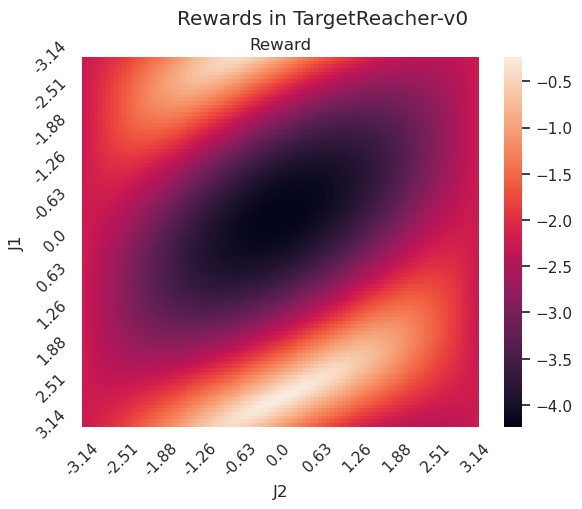

In [17]:
# Create the reward plot
num_ticks = 10
tick_skip = max(1, npoints // num_ticks)
tick_shift = 2*np.pi/npoints/2
tick_points = np.arange(npoints)[::tick_skip] + tick_shift
tick_labels = state_range.round(2)[::tick_skip]

sns.heatmap(rewards)
plt.xticks(tick_points, tick_labels, rotation=45)
plt.yticks(tick_points, tick_labels, rotation=45)
plt.xlabel("J2")
plt.ylabel("J1")
plt.title("Reward")
plt.suptitle("Rewards in %s" % env_name)
plt.show()


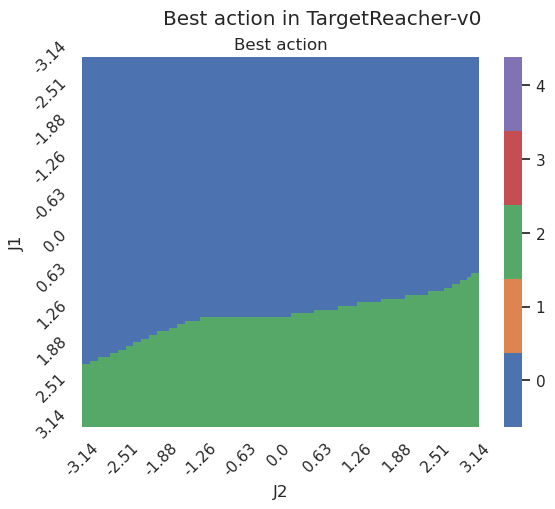

In [72]:
# # Create the policy plot
cmap = sns.color_palette("deep", action_space_dim)
sns.heatmap(actions, cmap=cmap, vmin=0, vmax=action_space_dim-1)
plt.xticks(tick_points, tick_labels, rotation=45)
plt.yticks(tick_points, tick_labels, rotation=45)
colorbar = plt.gca().collections[0].colorbar
ticks = np.array(range(action_space_dim))*((action_space_dim-1)/action_space_dim)+0.5
colorbar.set_ticks(ticks)
if env.spec.id == "Reacher-v1":
    # In Reacher, we can replace 0..4 with more readable labels
    labels = ["J1+", "J1-", "J2+", "J2-", "Stop"]
else:
    labels = list(map(str, range(action_space_dim)))
colorbar.set_ticklabels(labels)
plt.xlabel("J2")
plt.ylabel("J1")
plt.title("Best action")
plt.suptitle("Best action in %s" % env_name)
plt.show()

<a id='3.2.1'></a>
<div class=" alert alert-warning">
    <h3><b>Student Question 4.1</b> Achieved Performance (5 points) </h3> 

Where are the highest and lowest reward achieved?
            
🔝	<a href='#TOC'><b>Table of Contents</b></a>
</div>


In [19]:
print(f'lowest reward: {rewards.min()}, highest reward: {rewards.max()}')

lowest reward: -4.235768358395965, highest reward: -0.23759754940536468


<a id='Q5'></a>
<div class=" alert alert-warning">
    <h3><b>Student Question 4.2</b> Analysis of Behaviour (10 points) </h3> 

Did the policy learn to reach the goal from every possible state (manipulator configuration) in an optimal way (i.e. with lowest possible number of steps)? Why/why not?
            
🔝	<a href='#TOC'><b>Table of Contents</b></a>
</div>

The agent doesn't explore every possible state, so we can not be sure whether its policy is optimal. For the binary reward function, the agent also doesn't try to minimize the steps taken. For the negative distance reward, the agent will try to minimize the steps.

# 4. Submitting <a id='4.'></a>
Ensure all tasks and questions (in ```ex1.ipynb```) are answered and the relevant plots are recorded in the relevant places. Details about attaching images and figures can be found below. The relevant graphs to be included for this assignment are:
- Task 1, WandB CartPole ```episodesep_reward``` plot
- x2 Task 4 reward plots

Ensure the correct model files are saved:
- results/model/CartPole-v1_params.pt
- results/model/SpinningReacher-v0_params.pt
- results/model/TargetReacher-v0_params.pt

## 4.1 Feedback <a id='4.1'></a>
In order to help the staff of the course as well as the forthcoming students, it would be great if you could
answer feedback questionnaire in ```feedback.ipynb```

Please use the following section to record references.
# References <a id='5.'></a>